In [1]:
import sys
sys.path.append("/home/maciej/repos/scikit-learn")

import cv2
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from dataset_io import *
import numpy as np
from joblib import dump, load
import timeit
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Gradient features - RandomForest

In [8]:
# pallet_X=np.load(PROJECT_PATH+"pallet_rectangles_gradient.npy")
# background_X=np.load(PROJECT_PATH+"background_rectangles_gradient.npy")

# pallet_X=[np.dstack(x) for x in pallet_X]
# background_X=[np.dstack(x) for x in background_X]

# print(np.array(pallet_X).shape)
# print(np.array(background_X).shape)

# pallet_X=[x.flatten() for x in pallet_X]
# background_X=[x.flatten() for x in background_X]

# pallet_y=np.ones(len(pallet_X))
# background_y=np.zeros(len(background_X))

# X=np.vstack((pallet_X,background_X))
# y=np.hstack((pallet_y,background_y))

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
# sss.get_n_splits(X, y)
# train_index, test_index = list(sss.split(X, y))[0]
# X_train, X_test = X[train_index], X[test_index]
# y_train, y_test = y[train_index], y[test_index]

In [6]:
def get_gradient_data(train_scenes, test_scenes):
    def get_samples(feature, scenes, y_val):
        X = [np.load(get_existing_clf_ds_filepath(feature, s)) for s in scenes]
        X = np.concatenate(X)
        X=[np.dstack(x) for x in X]
        X=[x.flatten() for x in X]
        y=np.full(len(X), y_val)
        return X,y

    train_pallet_X, train_pallet_y=get_samples("pallet_rectangles_gradient", train_scenes, 1)
    train_background_X, train_background_y=get_samples("background_rectangles_gradient", train_scenes, 0)

    test_pallet_X, test_pallet_y=get_samples("pallet_rectangles_gradient", test_scenes, 1)
    test_background_X, test_background_y=get_samples("background_rectangles_gradient", test_scenes, 0)

    X_train = np.vstack((train_pallet_X,train_background_X))
    X_test = np.vstack((test_pallet_X,test_background_X))
    y_train = np.hstack((train_pallet_y,train_background_y))
    y_test = np.hstack((test_pallet_y,test_background_y))
    
    return X_train, X_test, y_train, y_test

In [7]:
def classify_gradient(train_scenes, test_scenes, fold_name, persist=False)
    X_train, X_test, y_train, y_test = get_gradient_data(train_scenes, test_scenes)
    clf = RandomForestClassifier(128, n_jobs=-1) #128 is as fast as lower sizes and as accurate as greater sizes
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)

    acc=accuracy_score(y_test, y_pred)
    prec=precision_score(y_test, y_pred)
    rec=recall_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    
    if persist:
        dump(clf, "rand_forest_clf_{}.joblib".format(fold_name)) 
    #print("acc: ",acc," f1: ",f1," prec: ",prec," rec: ",rec)
    return acc, prec, rec, f1, clf

acc:  0.945985401459854  f1:  0.8438818565400844  prec:  1.0  rec:  0.7299270072992701


[[548   0]
 [ 37 100]]


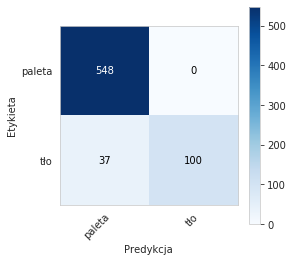

In [9]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etykieta',
           xlabel='Predykcja')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

#visualize_confusion_matrix(y_test, y_pred, ["paleta", "tło"], title=None)

# Color features - NaiveBayes

In [12]:
# pallet_pix_counts=[41068636, 2327190, 22568602]
# pallet_pix_count_map=dict(zip(COLORS, pallet_pix_counts))

In [13]:
# def readnsplit(color):
#     #-------------y-------------------------
#     pallet_pix_count=pallet_pix_count_map[color]
#     background_pix_count=pallet_pix_count*2
    
#     pallet_y=np.ones(pallet_pix_count, dtype=bool)
#     background_y=np.zeros(background_pix_count, dtype=bool)

#     y=np.hstack((pallet_y,background_y))

#     pallet_y=None
#     background_y=None

#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
#     sss.get_n_splits(y, y)
#     train_index, test_index = list(sss.split(y, y))[0]
#     sss=None

#     y_train, y_test = y[train_index], y[test_index]
#     y=None

#     #-------------X-------------------------
#     background_X=np.load(PROJECT_PATH+"backgrounds_color.npy", allow_pickle=True)
#     background_X=np.array([np.hstack(x) for x in background_X])
#     background_X=np.concatenate(background_X, 0)
#     indices=range(len(background_X))
#     indices=random.sample(indices, background_pix_count)
#     background_X=background_X[indices]
    
#     pallet_X=np.load(PROJECT_PATH+"pallets_color_{}.npy".format(color), allow_pickle=True)
#     pallet_X=np.array([np.hstack(x) for x in pallet_X])
#     pallet_X=np.concatenate(pallet_X, 0)

#     X=np.vstack((pallet_X,background_X))

#     pallet_X=None
#     background_X=None

#     X_train, X_test = X[train_index], X[test_index]
#     X=None
#     return X_train, X_test, y_train, y_test

In [34]:
def get_color_data(train_scenes, test_scenes, color):
    def get_samples(feature, scenes, y_val, color=None):
        X = [np.load(get_existing_clf_ds_filepath(feature, s, color), allow_pickle=True) for s in scenes]
        X = [x for x in X if len(x) > 0]
        X = np.concatenate(X)
        X = np.array([np.hstack(x) for x in X])
        X= np.concatenate(X, 0)
        y=np.full(len(X), y_val)
        return X,y

    train_pallet_X, train_pallet_y=get_samples("pallets_color", train_scenes, 1, color)
    train_background_X, train_background_y=get_samples("backgrounds_color", train_scenes, 0)

    test_pallet_X, test_pallet_y=get_samples("pallets_color", test_scenes, 1, color)
    test_background_X, test_background_y=get_samples("backgrounds_color", test_scenes, 0)

    X_train = np.vstack((train_pallet_X,train_background_X))
    X_test = np.vstack((test_pallet_X,test_background_X))
    y_train = np.hstack((train_pallet_y,train_background_y))
    y_test = np.hstack((test_pallet_y,test_background_y))
    
    return X_train, X_test, y_train, y_test

In [35]:
def classify_color(color, train_scenes, test_scenes, fold_name, persist):  
    X_train, X_test, y_train, y_test=get_color_data(train_scenes, test_scenes, color)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    X_train=None
    y_train=None
    y_pred=clf.predict(X_test)
    X_test=None

    acc=accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    prec=precision_score(y_test, y_pred)
    rec=recall_score(y_test, y_pred)
    cm=confusion_matrix(y_test, y_pred, labels=[True, False])

    if persist:
        dump(clf, 'naive_bayes_clf_{}_{}.joblib'.format(color, fold_name))
    #     print("acc: ",acc," f1: ",f1," prec: ",prec," rec: ",rec)
    #     print(cm)
    return acc, prec, rec, f1, clf


In [36]:
def classify_colors(train_scenes, test_scenes, fold_name, persist=False):
    for color in COLORS:
        classify_color(color, train_scenes, test_scenes, fold_name, persist)

blue
acc:  0.9162741484906277  f1:  0.8451655212794522  prec:  0.7801153604387941  rec:  0.9220510320372187
[[2212798  187067]
 [ 623703 6660060]]
dark
acc:  0.9203908959244943  f1:  0.6519227719029129  prec:  0.558045092505196  rec:  0.783773899846273
[[ 600091  165552]
 [ 475254 6808509]]
wooden
acc:  0.9503026851177495  f1:  0.7017684616163444  prec:  0.5988835548201028  rec:  0.8473361623623071
[[ 457459   82420]
 [ 306394 6977369]]
